Cell 1: Setup, Imports, and Configuration

In [ ]:
# Cell 1: Setup, Imports, and Configuration

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import shutil # For moving files/directories
import kagglehub # For Kaggle download method
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # For confusion matrix visualization

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# --- Model Configuration ---
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 50 # Initial training epochs
FINE_TUNE_EPOCHS = 20 # Additional epochs for fine-tuning
LEARNING_RATE = 0.0001 # Initial learning rate for transfer learning (frozen base)
FINE_TUNE_LEARNING_RATE = 0.00001 # 1e-5 (or even 1e-6) is common for fine-tuning
VALIDATION_SPLIT = 0.2 # 20% of the data for validation
RANDOM_SEED = 42 # For reproducibility of data splits

# --- File Paths Configuration ---
# Kaggle dataset identifier
KAGGLE_DATASET_NAME = 'vencerlanz09/agricultural-pests-image-dataset'

# Final directory where your structured pest image data will reside for model training
# This 'data/pests' folder will be populated by the Kaggle download/structuring step.
FINAL_DATA_DIR = '../data/pests'

# Paths for saving the trained model and class labels
# IMPORTANT: Model will be saved as .h5 to ensure broader compatibility
MODEL_SAVE_PATH = '../models/pest_classifier1.h5'
LABELS_SAVE_PATH = '../models/class_labels.json'

# Create necessary directories if they don't exist
os.makedirs(FINAL_DATA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True) # Creates '../models'

print("Configuration and directories set up.")

TensorFlow Version: 2.18.0
Num GPUs Available: 1
Configuration and directories set up.


Cell 2: Download, Unzip, and Structure Kaggle Dataset (Using kagglehub)

In [ ]:
# Cell 2: Download, Unzip, and Structure Kaggle Dataset (Using kagglehub)

print("\n--- Cell 2: Downloading and Preparing the Dataset ---")

# 1. Download dataset using kagglehub
print(f"Downloading dataset '{KAGGLE_DATASET_NAME}' from KaggleHub...")
try:
    # kagglehub usually returns a path to the extracted dataset's root
    download_path = kagglehub.dataset_download(KAGGLE_DATASET_NAME)
    print(f"Dataset downloaded and extracted to: {download_path}")
except Exception as e:
    print(f"Error downloading from KaggleHub: {e}")
    print("Please ensure 'kagglehub' is installed and your Kaggle API key is correctly set up.")
    # Exit or raise error if download fails
    raise

# 2. Inspect the contents of the downloaded path to identify the correct subfolder
print(f"\nListing contents of the downloaded path to find the actual image root: {download_path}")
downloaded_contents = []
try:
    downloaded_contents = os.listdir(download_path)
    print("Contents:", downloaded_contents)
    if not downloaded_contents:
        print("Warning: Downloaded path appears empty. This might indicate an issue with the download or an archive that needs further extraction.")
except Exception as e:
    print(f"Error listing contents: {e}")

# 3. Determine the actual source data root based on inspection
# For 'vencerlanz09/agricultural-pests-image-dataset', the data is usually inside 'Agricultural Pests'
# Based on the previous run's output, the class folders are directly in the download_path.
source_data_root = download_path
print(f"Identified '{source_data_root}' as the likely source data root.")


# 4. Copy data to FINAL_DATA_DIR in the expected structure
print(f"\nStructuring data from '{source_data_root}' to '{FINAL_DATA_DIR}'...")
if os.path.exists(source_data_root) and os.path.isdir(source_data_root):
    # Create necessary directories if they don't exist
    os.makedirs(FINAL_DATA_DIR, exist_ok=True)

    # Iterate through items (expected to be class folders) in the source_data_root
    for item in os.listdir(source_data_root):
        s = os.path.join(source_data_root, item) # Source path for a class folder
        d = os.path.join(FINAL_DATA_DIR, item)   # Destination path for a class folder

        if os.path.isdir(s): # If it's a directory (i.e., a class folder)
            if not os.path.exists(d): # If destination directory does not exist, copy the whole tree
                try:
                    print(f"  Copying class folder: '{item}' to '{FINAL_DATA_DIR}'")
                    shutil.copytree(s, d)
                    print(f"  Finished copying class folder: '{item}'")
                except Exception as e:
                    print(f"  Error copying folder '{item}': {e}")
            else:
                # If the folder exists, iterate through its contents and copy files if they don't exist
                print(f"  Class folder '{item}' already exists in '{FINAL_DATA_DIR}'. Merging contents...")
                try:
                    for filename in os.listdir(s):
                        src_file = os.path.join(s, filename)
                        dest_file = os.path.join(d, filename)
                        if os.path.isfile(src_file):
                            if not os.path.exists(dest_file):
                                shutil.copy2(src_file, dest_file) # copy2 preserves metadata
                                # print(f"    Copied file: {filename}") # Uncomment for verbose file copying
                            # else:
                                # print(f"    Skipping existing file: {filename}") # Uncomment for verbose file skipping
                        elif os.path.isdir(src_file):
                            print(f"    Skipping nested directory: {src_file}. Manual handling if needed.")
                    print(f"  Finished merging contents for class folder: '{item}'")
                except Exception as e:
                    print(f"  Error merging contents for folder '{item}': {e}")

        else:
            print(f"  Skipped non-directory item: '{item}' (e.g., a README file).")
    print("Data structuring complete.")
else:
    print(f"Error: Could not find the expected source data root: {source_data_root}.")
    print("Please manually inspect the output above and adjust 'source_data_root' if necessary.")
    # Exit or raise error if data not found
    raise ValueError(f"Source data root not found or is not a directory: {source_data_root}")


# 5. Verify the final data structure for TensorFlow
print(f"\nVerifying final data structure in {FINAL_DATA_DIR}:")
if os.path.exists(FINAL_DATA_DIR) and os.listdir(FINAL_DATA_DIR):
    print(f"Contents of {FINAL_DATA_DIR}: {os.listdir(FINAL_DATA_DIR)}")
    # Check if first subfolder contains files
    first_class_dir = os.path.join(FINAL_DATA_DIR, os.listdir(FINAL_DATA_DIR)[0])
    if os.path.isdir(first_class_dir):
        print(f"First class folder '{os.listdir(FINAL_DATA_DIR)[0]}' contents (first 5 files): {os.listdir(first_class_dir)[:5]}")
else:
    print(f"Error: Final data directory {FINAL_DATA_DIR} is empty or does not exist.")
    raise ValueError(f"No structured image data found in {FINAL_DATA_DIR}. Please check data download and structuring.")

print("\nKaggle data setup complete. Proceeding to next steps.")


--- Cell 2: Downloading and Preparing the Dataset ---
Dataset downloaded and extracted to: /kaggle/input/agricultural-pests-image-dataset

Listing contents of the downloaded path to find the actual image root: /kaggle/input/agricultural-pests-image-dataset
Contents: ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail', 'catterpillar', 'weevil', 'bees', 'moth', 'wasp', 'slug']
Identified '/kaggle/input/agricultural-pests-image-dataset' as the likely source data root.

Structuring data from '/kaggle/input/agricultural-pests-image-dataset' to '../data/pests'...
  Class folder 'beetle' already exists in '../data/pests'. Merging contents...
  Finished merging contents for class folder: 'beetle'
  Class folder 'grasshopper' already exists in '../data/pests'. Merging contents...
  Finished merging contents for class folder: 'grasshopper'
  Class folder 'earthworms' already exists in '../data/pests'. Merging contents...
  Finished merging contents for class folder: 'earthworms'
 

Cell 3: Load and Visualize the Dataset


--- Cell 3: Loading and Visualizing the Dataset ---
Found 5494 files belonging to 12 classes.
Using 4396 files for training.
Found 5494 files belonging to 12 classes.
Using 1098 files for validation.

Class names detected and saved to ../models/class_labels.json: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


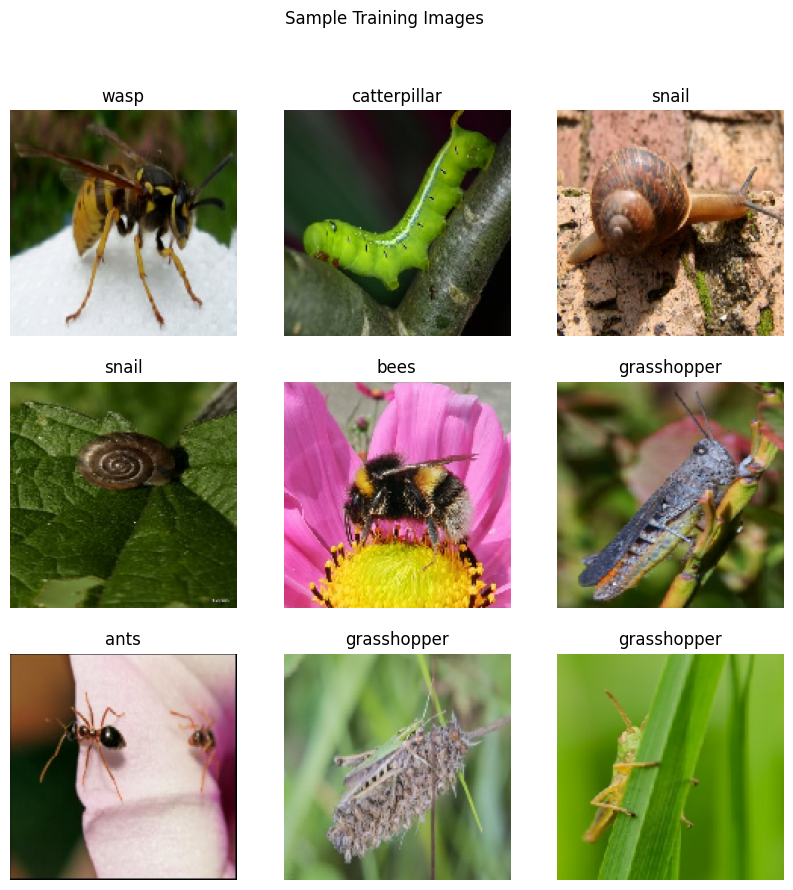

Datasets loaded and samples displayed.


In [ ]:
# Cell 3: Load and Visualize the Dataset

print("\n--- Cell 3: Loading and Visualizing the Dataset ---")

# Create training and validation datasets from FINAL_DATA_DIR
train_ds = tf.keras.utils.image_dataset_from_directory(
    FINAL_DATA_DIR,
    labels='inferred',
    label_mode='int', # Use 'int' for SparseCategoricalCrossentropy loss
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    FINAL_DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

# Get class names and save them (CRUCIAL for your FastAPI and Gradio apps)
class_names = train_ds.class_names
with open(LABELS_SAVE_PATH, 'w') as f:
    json.dump(class_names, f)
print(f"\nClass names detected and saved to {LABELS_SAVE_PATH}: {class_names}")

# Display a few sample images and their labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

print("Datasets loaded and samples displayed.")

Cell 4: Data Preprocessing and Augmentation Pipeline

In [ ]:
# Cell 4: Data Preprocessing and Augmentation Pipeline

print("\n--- Cell 4: Data Preprocessing and Augmentation Pipeline ---")

# --- Data Preprocessing Layer ---
# This layer scales pixel values from [0, 255] to [0, 1].
# THIS IS CRITICAL: It MUST match the normalization in your `src/prediction.py`.
normalization_layer = layers.Rescaling(1./255)

# --- Data Augmentation Layers ---
# These transformations artificially increase the diversity of your training data.
# They are applied ONLY during training to prevent overfitting.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2), # Rotate by up to 20%
    layers.RandomZoom(0.2),     # Zoom by up to 20%
    layers.RandomContrast(0.2), # Adjust contrast by up to 20%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Shift image by up to 10%
], name="data_augmentation_layer")

# --- Apply Preprocessing and Augmentation to Datasets ---
# Apply normalization to both training and validation datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Apply data augmentation ONLY to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Optimize for performance: cache and prefetch data for faster training
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets prepared with normalization and augmentation applied to training data.")


--- Cell 4: Data Preprocessing and Augmentation Pipeline ---
Datasets prepared with normalization and augmentation applied to training data.


Cell 5: Build the Model (Transfer Learning with MobileNetV2)

In [ ]:
# Cell 5: Build the Model (Transfer Learning with MobileNetV2)

print("\n--- Cell 5: Building the Model Architecture ---")

num_classes = len(class_names)

# 1. Load a pre-trained base model (e.g., MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model for initial training
# We'll unfreeze it later for fine-tuning
base_model.trainable = False

# 3. Build the model using the Keras Functional API
# This explicitly defines the input and how tensors flow between layers,
# which can be more robust for saving/loading.
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Pass the input through the base_model.
# Set training=False here for the base_model to ensure batch normalization
# and dropout layers (if any in MobileNetV2) behave in inference mode,
# which is typical for a frozen base.
x = base_model(inputs, training=False)

# Add the custom classification head
x = layers.GlobalAveragePooling2D()(x) # Flattens to (None, 1280)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = keras.Model(inputs=inputs, outputs=outputs)

# Display initial model summary (before fine-tuning)
print("Model summary before initial training:")
model.summary()

print("Model architecture built using Transfer Learning with MobileNetV2 (Functional API).")


--- Cell 5: Building the Model Architecture ---


/tmp/ipython-input-1987890115.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model summary before initial training:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,500 (9.24 MB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model architecture built using Transfer Learning with MobileNetV2 (Functional API).


Cell 6: Compile the Model

In [ ]:
# Cell 6: Compile the Model (Initial Training Phase)

print("\n--- Cell 6: Compiling the Model (Initial Training) ---")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

print("Model compiled for initial training.")


--- Cell 6: Compiling the Model (Initial Training) ---
Model compiled for initial training.


Cell 7: Callbacks for Training Control (Early Stopping)



In [ ]:
# Cell 7: Callbacks for Training Control (Early Stopping)

print("\n--- Cell 7: Defining Callbacks ---")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=10,                # Number of epochs with no improvement to wait
    restore_best_weights=True,  # Restore model weights from the epoch with the best monitored value
    verbose=1
)

callbacks = [early_stopping]

print("Callbacks defined.")


--- Cell 7: Defining Callbacks ---
Callbacks defined.


Cell 8: Train the Model



In [ ]:
# Cell 8: Train the Model (Initial Training Phase)

print("\n--- Cell 8: Starting Initial Model Training ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS, # Use initial EPOCHS
    callbacks=callbacks
)

print("Initial model training finished.")


--- Cell 8: Starting Initial Model Training ---
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 46s 276ms/step - accuracy: 0.1743 - loss: 2.5991 - val_accuracy: 0.6740 - val_loss: 1.2415
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4314 - loss: 1.7500 - val_accuracy: 0.8024 - val_loss: 0.7536
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5431 - loss: 1.4355 - val_accuracy: 0.8270 - val_loss: 0.6080
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6007 - loss: 1.2608 - val_accuracy: 0.8470 - val_loss: 0.5198
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6224 - loss: 1.1490 - val_accuracy: 0.8689 - val_loss: 0.4490
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6468 - loss: 1.0573 - val_accuracy: 0.8625 - val_loss: 0.4497
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6773 - loss: 0.9872 - val_accuracy: 0.8670 - val_loss: 0.4151
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20m

Cell 9: Visualize Training History


--- Cell 9: Visualizing Initial Training History ---


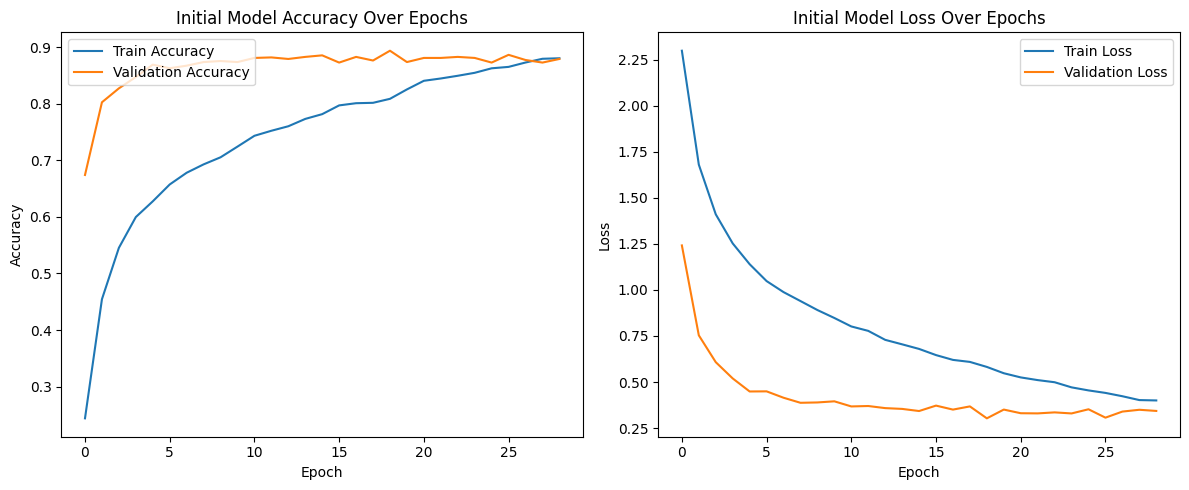

Initial training history visualized (Accuracy and Loss plots).


In [ ]:
# Cell 9: Visualize Initial Training History

print("\n--- Cell 9: Visualizing Initial Training History ---")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Initial training history visualized (Accuracy and Loss plots).")

Cell 10: Fine-tuning Preparation: Unfreeze Base Model and Recompile

In [ ]:
# Cell 10: Fine-tuning Preparation: Unfreeze Base Model and Recompile

print("\n--- Cell 10: Preparing for Fine-tuning ---")

# It's important to unfreeze the base model *before* recompiling.
# We set base_model.trainable to True, which means all layers within base_model
# will now be trainable.
base_model.trainable = True
print(f"Base model '{base_model.name}' is now trainable.")

# Let's see how many layers are now trainable
print("\nTrainable layers in the full model after unfreezing base_model:")
for layer in model.layers:
    print(f"{layer.name}: Trainable={layer.trainable}")

# Recompile the model with a much lower learning rate for fine-tuning.
# This is CRITICAL! Changes to `trainable` status only take effect after recompilation.
# A very low learning rate prevents drastic changes to the pre-trained weights.
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE)

model.compile(
    optimizer=fine_tune_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\nModel recompiled with a new (lower) learning rate for fine-tuning.")
print(f"New learning rate for fine-tuning: {FINE_TUNE_LEARNING_RATE}")


--- Cell 10: Preparing for Fine-tuning ---
Base model 'mobilenetv2_1.00_224' is now trainable.

Trainable layers in the full model after unfreezing base_model:
input_layer_13: Trainable=True
mobilenetv2_1.00_224: Trainable=True
global_average_pooling2d_4: Trainable=True
dense_8: Trainable=True
dropout_4: Trainable=True
dense_9: Trainable=True

Model recompiled with a new (lower) learning rate for fine-tuning.
New learning rate for fine-tuning: 1e-05


Cell 11: Fine-tuning Training

In [ ]:
# Cell 11: Fine-tuning Training

print("\n--- Cell 11: Starting Fine-tuning ---")

# Get the number of epochs already run from the initial training history
initial_epochs = len(history.epoch) if history.epoch else 0

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs + FINE_TUNE_EPOCHS, # Total epochs will be initial + fine-tune epochs
    initial_epoch=initial_epochs, # Start from where previous training left off
    callbacks=callbacks # Use the same early stopping callback
)

print("\nFine-tuning finished.")


--- Cell 11: Starting Fine-tuning ---
Epoch 30/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 74s 219ms/step - accuracy: 0.5180 - loss: 1.4307 - val_accuracy: 0.9299 - val_loss: 0.2079
Epoch 31/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7024 - loss: 0.9188 - val_accuracy: 0.9271 - val_loss: 0.2016
Epoch 32/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7851 - loss: 0.7161 - val_accuracy: 0.9281 - val_loss: 0.1979
Epoch 33/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8318 - loss: 0.5852 - val_accuracy: 0.9235 - val_loss: 0.2063
Epoch 34/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8701 - loss: 0.4785 - val_accuracy: 0.9226 - val_loss: 0.2181
Epoch 35/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9033 - loss: 0.3956 - val_accuracy: 0.9253 - val_loss: 0.2193
Epoch 36/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9237 - loss: 0.3313 - val_accuracy: 0.9226 - val_loss: 0.2266
Epoch 37/49
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms

Cell 12: Visualize Combined Training History (Initial + Fine-tuning)


--- Cell 12: Visualizing Combined Training History ---


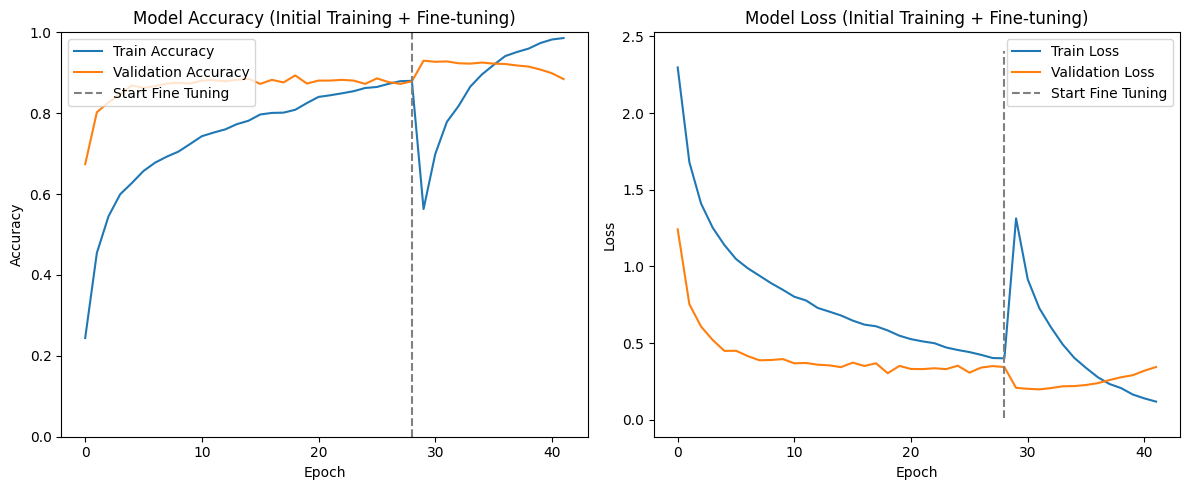

Combined training history visualized.


In [68]:
# Cell 12: Visualize Combined Training History (Initial + Fine-tuning)

print("\n--- Cell 12: Visualizing Combined Training History ---")

# Combine the history objects
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning', color='gray', linestyle='--')
plt.title('Model Accuracy (Initial Training + Fine-tuning)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning', color='gray', linestyle='--')
plt.title('Model Loss (Initial Training + Fine-tuning)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Combined training history visualized.")

Cell 13: Evaluate the Fine-tuned Model (Detailed Metrics)


--- Cell 13: Fine-tuned Model Evaluation on Validation Set ---
Validation Loss (Fine-tuned): 0.1979
Validation Accuracy (Fine-tuned): 0.9281

--- Classification Report (Fine-tuned Model) ---
              precision    recall  f1-score   support

        ants       0.00      0.00      0.00         0
        bees       0.00      0.00      0.00         0
      beetle       0.00      0.00      0.00         0
catterpillar       0.00      0.00      0.00         0
  earthworms       0.00      0.00      0.00         0
      earwig       0.00      0.00      0.00         0
 grasshopper       0.00      0.00      0.00         0
        moth       0.00      0.00      0.00         0
        slug       0.00      0.00      0.00         0
       snail       0.99      1.00      1.00       115
        wasp       1.00      0.85      0.92       498
      weevil       0.99      0.99      0.99       485

    accuracy                           0.93      1098
   macro avg       0.25      0.24      0.24      1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

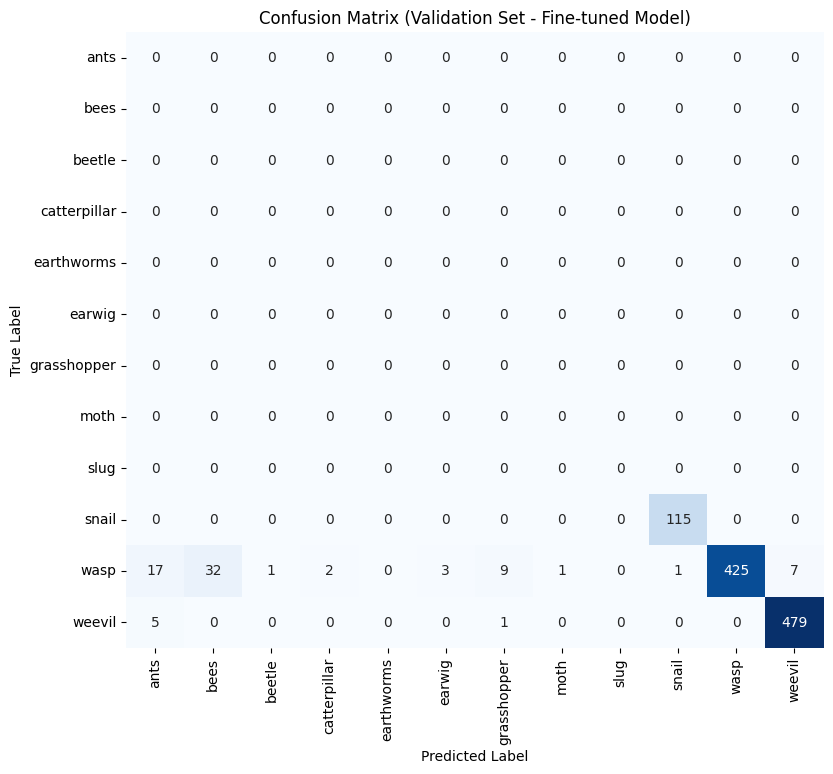


Detailed fine-tuned model evaluation complete.


In [69]:
# Cell 13: Evaluate the Fine-tuned Model (Detailed Metrics)

print("\n--- Cell 13: Fine-tuned Model Evaluation on Validation Set ---")

# 1. Get overall Loss and Accuracy
loss, accuracy = model.evaluate(val_ds, verbose=0)
print(f"Validation Loss (Fine-tuned): {loss:.4f}")
print(f"Validation Accuracy (Fine-tuned): {accuracy:.4f}")

# 2. Get predictions and true labels for detailed metrics
val_labels = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
val_predictions_prob = model.predict(val_ds, verbose=0)
val_predicted_ids = np.argmax(val_predictions_prob, axis=1)

# 3. Generate Classification Report (Precision, Recall, F1-score)
print("\n--- Classification Report (Fine-tuned Model) ---")
# Pass the unique labels present in the true labels to classification_report
print(classification_report(val_labels, val_predicted_ids, target_names=class_names, labels=np.arange(len(class_names))))

# 4. Generate Confusion Matrix (Visualizing correct/incorrect classifications)
print("\n--- Confusion Matrix (Fine-tuned Model) ---")
# Pass the unique labels present in the true labels to confusion_matrix
cm = confusion_matrix(val_labels, val_predicted_ids, labels=np.arange(len(class_names)))
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False)
plt.title('Confusion Matrix (Validation Set - Fine-tuned Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nDetailed fine-tuned model evaluation complete.")

Cell 14: Save the Fine-tuned Model

In [70]:
# Cell 14: Save the Fine-tuned Model

print("\n--- Cell 14: Saving the Fine-tuned Model ---")

# MODEL_SAVE_PATH is set to .h5 in Cell 1
model.save(MODEL_SAVE_PATH)
print(f"\nFine-tuned model saved to: {os.path.abspath(MODEL_SAVE_PATH)}")
print("Fine-tuned model saved successfully.")

print("Notebook execution complete. Model fine-tuned and saved for deployment.")


--- Cell 14: Saving the Fine-tuned Model ---

Fine-tuned model saved to: /models/pest_classifier1.h5
Fine-tuned model saved successfully.
Notebook execution complete. Model fine-tuned and saved for deployment.
